# Suspicious Score

In [2]:
import pandas as pd
import numpy as np

In [3]:
from sklearn import preprocessing

In [4]:
def load_dataset(path):
    df = pd.read_csv(path, index_col=0)
    return df

In [73]:
def look_at_group(group_id, df_charlotte_2016, df_groups):
    df = df_charlotte_2016.merge(df_groups, on='user_id')
    df = df[df.group_id==group_id]
    return df

## Raw Dataset

In [5]:
df_charlotte_2016 = load_dataset(r'D:\Yelp\charlotte_2016.csv')

In [6]:
df_charlotte_2016.head(1)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_business,review_count,...,categories,hours,review_id,user_id,stars_review,useful,funny,cool,text,date
8,0pOlmHVeidsh63iAWdTAfg,Hendrick Motors of Charlotte - Mercedes-Benz,5201 E Independence Blvd,Charlotte,NC,28212.0,35.188018,-80.758758,2.5,32,...,"Auto Repair, Car Dealers, Automotive","{'Monday': '0:0-0:0', 'Tuesday': '7:30-19:0', ...",VyiezkRspGtuG68_rDYp3A,A0R17nyHQ9SiqQjtnsP33g,1.0,5,0,0,Mercedes used to be such a great brand with ex...,2016-12-23 03:54:01


## Group Dataset

In [7]:
df_groups = load_dataset(r'D:\Yelp\charlotte_2016_groups.csv')

In [8]:
df_groups.tail()

,user_id,group_id,group_len,group_type
38276,hWDybu_KvYLSdEFzGrniTw,10385,6,a
38278,mcJ-A0OGmiWZGBbdWPMfrw,10386,6,a
38279,hWDybu_KvYLSdEFzGrniTw,10386,6,a
38280,xDl9ZF3SckkZde_48W6WeA,10386,6,a
38283,jcURiDqCLY7AOqo8KClJnQ,10386,6,a


In [9]:
df_groups.group_type.value_counts()

n    22741
a    10662
Name: group_type, dtype: int64

In [10]:
df_groups.group_id.max()

10386

## Reviewing Burstiness (BST) data

In [11]:
df_bst = load_dataset(r'D:\Yelp\bst_own_review_count_groups.csv')

In [12]:
df_bst.head(5)

,user_id,bst,own_review_count
0,--3WaS23LcIXtxyFULJHTA,0.964286,2
1,--7D3lFxyMYvs2JYiRrg6Q,0.000000,1
2,--JS-RvSykutl1DavCbkIg,0.000000,1
3,--OZO4c_vDOVC2z2BWr92A,0.964286,2
4,--wiweOmNCw6vg2kbzbwEA,0.000000,1


## Cosine similarity

In [13]:
df_cosine_similarity = load_dataset(r'D:\Yelp\cosine_groups.csv')

In [15]:
df_cosine_similarity.head(1)

,group_id,cosine_mean,cosine_max
0,0,0.319787,0.562996


## Extreme Raiting Abuse (EXT)

In [16]:
df_extreme_rating = load_dataset(r'D:\Yelp\extreme_rating_abuse.csv')

In [17]:
df_extreme_rating.head()

,user_id,ext
0,--3WaS23LcIXtxyFULJHTA,0
1,--7D3lFxyMYvs2JYiRrg6Q,1
2,--JS-RvSykutl1DavCbkIg,1
3,--wiweOmNCw6vg2kbzbwEA,1
4,-0CTuvVqlEGeWvOt82B7Hg,0


---

# Merge for Group! Features

In [18]:
df_g_features = df_charlotte_2016.merge(df_groups, on='user_id', how='inner')

In [19]:
df_g_features.shape

(435220, 25)

---

In [21]:
df_g_features = df_g_features.merge(df_bst, on='user_id', how='inner') 

---

In [23]:
df_g_features = df_g_features.merge(df_extreme_rating, on='user_id', how='inner') 

---

## Reduce

In [42]:
df_g_features_reduced = df_g_features[['group_id', 'group_len', 'group_type', 'bst', 'own_review_count', 'ext']]

In [43]:
df_g_features_reduced.head()

,group_id,group_len,group_type,bst,own_review_count,ext
0,6835,2,n,0.0,2,1
1,6835,2,n,0.0,2,1
2,6835,2,n,0.0,1,1
3,589,2,n,0.0,35,0
4,589,2,n,0.0,35,0


---

## Build Group Features

In [44]:
bst_mean = df_g_features_reduced.groupby('group_id').bst.mean().to_frame(name='bst_mean')

In [45]:
ext_mean = df_g_features_reduced.groupby('group_id').ext.mean().to_frame(name='ext_mean')

In [46]:
group_review_count_sum = df_g_features_reduced.groupby('group_id').own_review_count.sum().to_frame(name='group_review_count_sum')

In [47]:
group_review_count_mean = df_g_features_reduced.groupby('group_id').own_review_count.mean().to_frame(name='group_review_count_mean')

---

## Merge Group Features

In [48]:
df_group_features = bst_mean.merge(ext_mean, on='group_id')

In [49]:
df_group_features = df_group_features.merge(group_review_count_sum, on='group_id')

In [50]:
df_group_features = df_group_features.merge(group_review_count_mean, on='group_id')

In [51]:
df_group_features = df_group_features.merge(df_cosine_similarity, on='group_id')

In [52]:
df_group_features.head()

,group_id,bst_mean,ext_mean,group_review_count_sum,group_review_count_mean,cosine_mean,cosine_max
0,0,0.000000,1.0,6,1.500000,0.319787,0.562996
1,1,0.000000,1.0,5,1.666667,0.171883,0.219358
2,2,0.275510,0.0,29,4.142857,0.477529,0.664357
3,3,0.642857,1.0,5,1.666667,0.344743,0.398216
4,4,0.642857,1.0,5,1.666667,0.373724,0.496549


In [53]:
df_group_features.shape

(10387, 7)

---

## normalize

In [54]:
df_group_features['group_review_count_sum_normal'] = df_group_features['group_review_count_sum']/df_group_features['group_review_count_sum'].max()

In [55]:
df_group_features['group_review_count_mean_normal'] = df_group_features['group_review_count_mean']/df_group_features['group_review_count_mean'].max()

In [56]:
df_group_features.head()

,group_id,bst_mean,ext_mean,group_review_count_sum,group_review_count_mean,cosine_mean,cosine_max,group_review_count_sum_normal,group_review_count_mean_normal
0,0,0.000000,1.0,6,1.500000,0.319787,0.562996,0.000067,0.007462
1,1,0.000000,1.0,5,1.666667,0.171883,0.219358,0.000055,0.008291
2,2,0.275510,0.0,29,4.142857,0.477529,0.664357,0.000322,0.020610
3,3,0.642857,1.0,5,1.666667,0.344743,0.398216,0.000055,0.008291
4,4,0.642857,1.0,5,1.666667,0.373724,0.496549,0.000055,0.008291


In [58]:
df_group_features.head()

,group_id,bst_mean,ext_mean,group_review_count_sum,group_review_count_mean,cosine_mean,cosine_max,group_review_count_sum_normal,group_review_count_mean_normal
3075,3075,0.964286,0.086957,445,19.347826,0.250621,0.675521,0.004936,0.096253
10325,10325,0.964286,0.304348,171,7.434783,0.473847,0.786625,0.001897,0.036987
7816,7816,0.964286,0.157895,155,8.157895,0.529851,0.786625,0.001719,0.040585
1346,1346,0.964286,0.000000,450,18.750000,0.236999,0.675521,0.004992,0.093279
7817,7817,0.964286,0.388889,146,8.111111,0.441898,0.723633,0.001620,0.040352


In [59]:
df_group_features.index = df_group_features.index.map(str)

## Add suspicious score

In [64]:
df_group_features.columns

Index(['group_id', 'bst_mean', 'ext_mean', 'group_review_count_sum',
       'group_review_count_mean', 'cosine_mean', 'cosine_max',
       'group_review_count_sum_normal', 'group_review_count_mean_normal'],
      dtype='object')

In [66]:
df_group_features['suspicious_score'] =  (df_group_features['bst_mean'] 
                                            + df_group_features['ext_mean'] 
                                            + df_group_features['cosine_mean'] 
                                            + df_group_features['group_review_count_mean_normal'])/4

In [68]:
df_group_features = df_group_features.sort_values(by='suspicious_score', ascending=False)

In [69]:
df_group_features.head()

,group_id,bst_mean,ext_mean,group_review_count_sum,group_review_count_mean,cosine_mean,cosine_max,group_review_count_sum_normal,group_review_count_mean_normal,suspicious_score
6868,6868,0.964286,1.0,18,3.000000,0.440318,0.704904,0.000200,0.014925,0.604882
4089,4089,0.571429,1.0,5,1.666667,0.780472,1.000000,0.000055,0.008291,0.590048
3156,3156,0.642857,1.0,5,1.666667,0.691066,0.973269,0.000055,0.008291,0.585554
4423,4423,0.964286,1.0,8,2.000000,0.358964,0.609847,0.000089,0.009950,0.583300
1358,1358,0.964286,1.0,8,2.000000,0.354264,0.492545,0.000089,0.009950,0.582125


---

<AxesSubplot:title={'center':'suspicious_score'}>

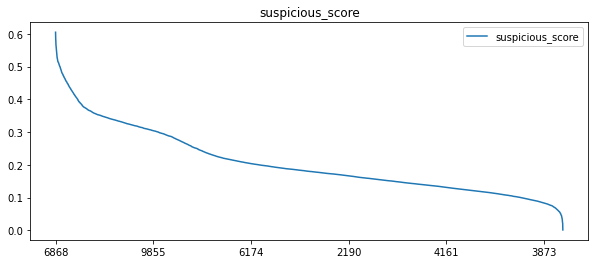

In [72]:
df_group_features[['suspicious_score']].plot(kind='line', figsize=(10,4), title='suspicious_score')

<AxesSubplot:>

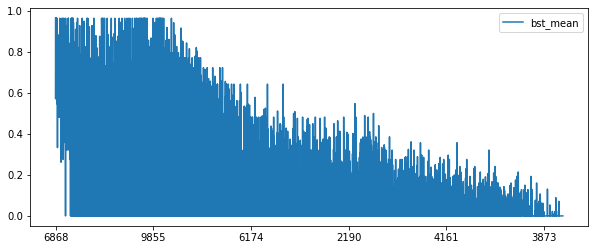

In [77]:
df_group_features[['bst_mean']].plot(kind='line', figsize=(10,4))

<AxesSubplot:>

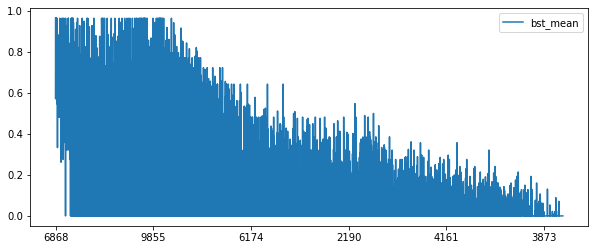

In [78]:
df_group_features[['bst_mean']].plot(kind='line', figsize=(10,4))

<AxesSubplot:>

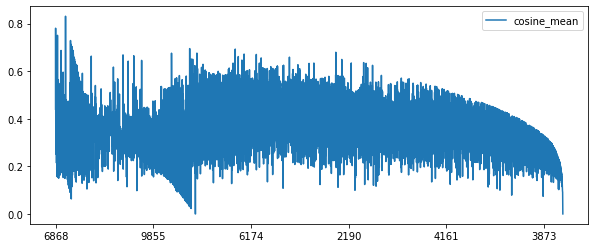

In [79]:
df_group_features[['cosine_mean']].plot(kind='line', figsize=(10,4))

<AxesSubplot:>

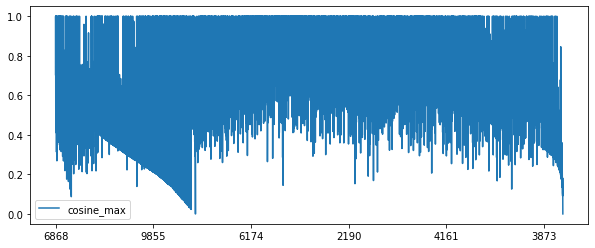

In [80]:
df_group_features[['cosine_max']].plot(kind='line', figsize=(10,4))

<AxesSubplot:>

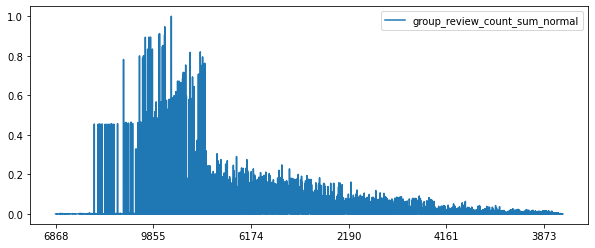

In [81]:
df_group_features[['group_review_count_sum_normal']].plot(kind='line', figsize=(10,4))

<AxesSubplot:>

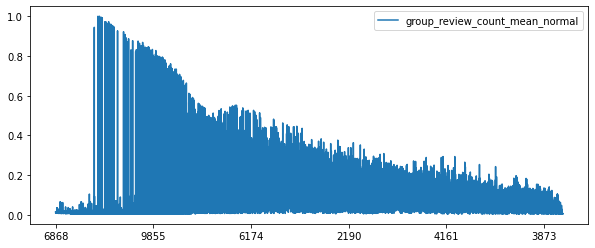

In [82]:
df_group_features[['group_review_count_mean_normal']].plot(kind='line', figsize=(10,4))

In [76]:
look_at_group(4089, df_charlotte_2016, df_groups).text

435148    I purchased a 2013 absolutely perfect certifie...
435151    I purchased a 2013 absolutely perfect certifie...
435154    Communication after the sale? Bahahahaha! What...
Name: text, dtype: object